In [0]:
import pandas as pd
import numpy as np
import random
import os
import cv2
import glob
import sklearn
import matplotlib.pyplot as plt
import tensorflow as tf

### Загрузка датасета в colab

In [0]:
!pip install -U -q PyDrive 

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':"1lvAO69ahQWiNsM5yg_TWN7oELw6RhKox"})
downloaded.GetContentFile('gtsrb.zip')
!unzip ./gtsrb.zip
!mkdir -p datasets/GTSRB
!mkdir log
!mv ./gtsrb/* ./datasets/GTSRB

In [4]:
!ls -l ./datasets/GTSRB

total 6604
-rw-r--r--  1 root root  321114 Dec 18  2015 gt_test.csv
-rw-r--r--  1 root root  988653 Dec 18  2015 gt_train.csv
drwx------  2 root root    4096 Jun 24 13:29 Meta
-rwxr-xr-x  1 root root    1033 Nov 25  2018 Meta.csv
-rw-r--r--  1 root root     951 Dec 18  2015 numbers_to_classes.csv
drwxr-xr-x  2 root root  638976 Jul  4 16:18 test
drwx------  2 root root  364544 Jun 24 13:28 Test
-rwxr-xr-x  1 root root  427897 Nov 25  2018 Test.csv
drwxr-xr-x  2 root root 2043904 Jul  4 16:19 train
drwx------ 45 root root    4096 Jun 24 13:29 Train
-rwxr-xr-x  1 root root 1940896 Nov 25  2018 Train.csv


In [0]:
import pandas as pd
import os

In [0]:
data = pd.read_csv(os.path.join("./datasets/GTSRB/", "Test.csv"), ",")

In [6]:
data.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


###Подготовка данных

In [0]:
import pandas as pd
import numpy as np
import random
import os
import cv2
import glob
import sklearn
import matplotlib.pyplot as plt
import tensorflow as tf

In [0]:
NUM_CLASSES = 43
IMG_SHAPE = (50,50,3)
DATASET_DIR = "./datasets/GTSRB/"

#### Парсинг аннотации и подготовка изображений

In [0]:
def get_dataset(data):
    data = sklearn.utils.shuffle(data)
    images = []
    labels = []
    for v in data.itertuples():
        image_path = os.path.join(DATASET_DIR, v.Path)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        scaled_img = cv2.resize(image, (IMG_SHAPE[:2]))
        images.append(scaled_img)
        labels.append(int(v.ClassId))
    
    return np.array(images, dtype="float32")/255.0, labels

In [0]:
reference_annotation = pd.read_csv(os.path.join(DATASET_DIR, "Meta.csv"), ",")
x_reference, y_reference = get_dataset(reference_annotation)

#### Загрузка аннотации к данным

In [0]:
train_annotation = pd.read_csv(os.path.join(DATASET_DIR, "Train.csv"), ",")
test_annotation = pd.read_csv(os.path.join(DATASET_DIR, "Test.csv"), ",")

#### Загрузка изображений

In [0]:
x_train, y_train = get_dataset(train_annotation)
x_test, y_test = get_dataset(test_annotation)

#### Загрузка образцов

In [0]:
reference_annotation = pd.read_csv(os.path.join(DATASET_DIR, "Meta.csv"), ",")
x_reference, y_reference = get_dataset(reference_annotation)

**Приведение метаданных к удобному формату**

In [0]:
reference_array = np.array(sorted(zip(x_reference, y_reference), key=lambda v: v[1]))[:,0]

#### Визуализация

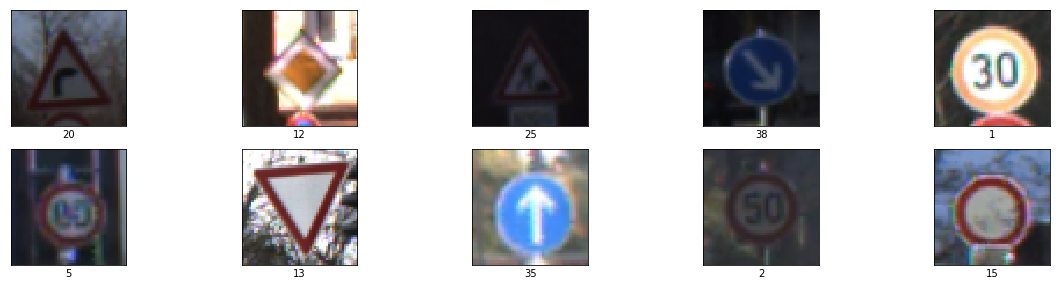

In [15]:
plt.figure(figsize=(20,20))
for num, im_id in enumerate(np.random.choice(len(x_train), 10)):
    plt.subplot(8,5,num+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[im_id], cmap=plt.cm.binary)
    plt.xlabel(y_train[im_id])
    
plt.show()

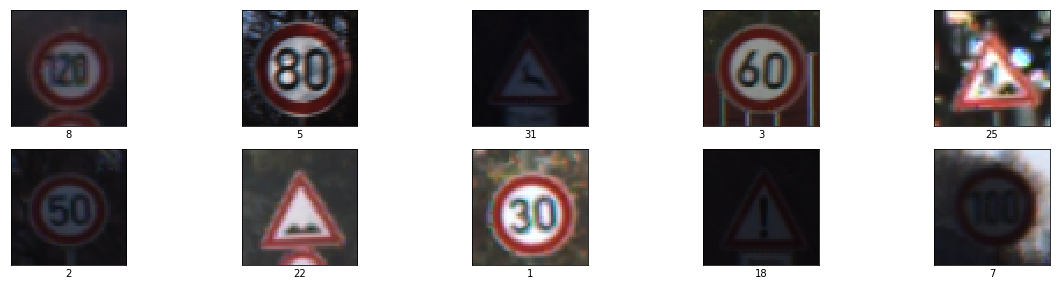

In [16]:
plt.figure(figsize=(20,20))
for num, im_id in enumerate(np.random.choice(len(x_test), 10)):
    plt.subplot(8,5,num+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[im_id], cmap=plt.cm.binary)
    plt.xlabel(y_test[im_id])
    
plt.show()

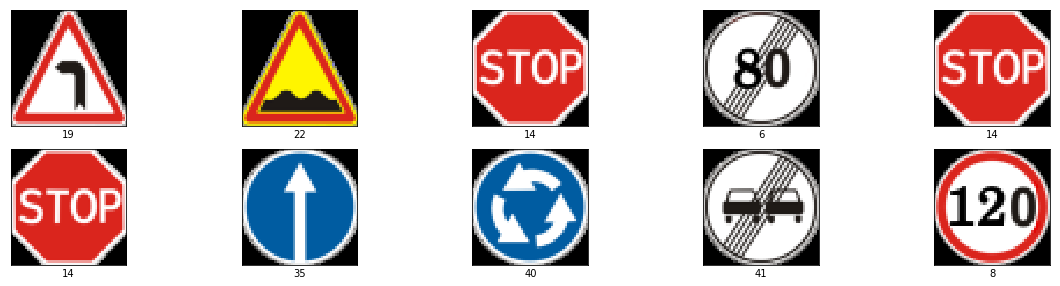

In [17]:
plt.figure(figsize=(20,20))
for num, im_id in enumerate(np.random.choice(len(x_reference), 10)):
    plt.subplot(8,5,num+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_reference[im_id], cmap=plt.cm.binary)
    plt.xlabel(y_reference[im_id])
    
plt.show()

### Формирование модели

In [0]:
IMG_SHAPE = (50,50,3)

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(50, (3,3), input_shape=IMG_SHAPE, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(50, (3,3), activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.MaxPooling2D(2),

    tf.keras.layers.Conv2D(100, (3,3), activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(100, (3,3), activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(200, (3,3), activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.MaxPooling2D(2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(400, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(43, activation=tf.nn.softmax)
])


In [42]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 48, 48, 50)        1400      
_________________________________________________________________
dropout_24 (Dropout)         (None, 48, 48, 50)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 46, 46, 50)        22550     
_________________________________________________________________
dropout_25 (Dropout)         (None, 46, 46, 50)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 23, 23, 50)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 21, 21, 100)       45100     
_________________________________________________________________
dropout_26 (Dropout)         (None, 21, 21, 100)      

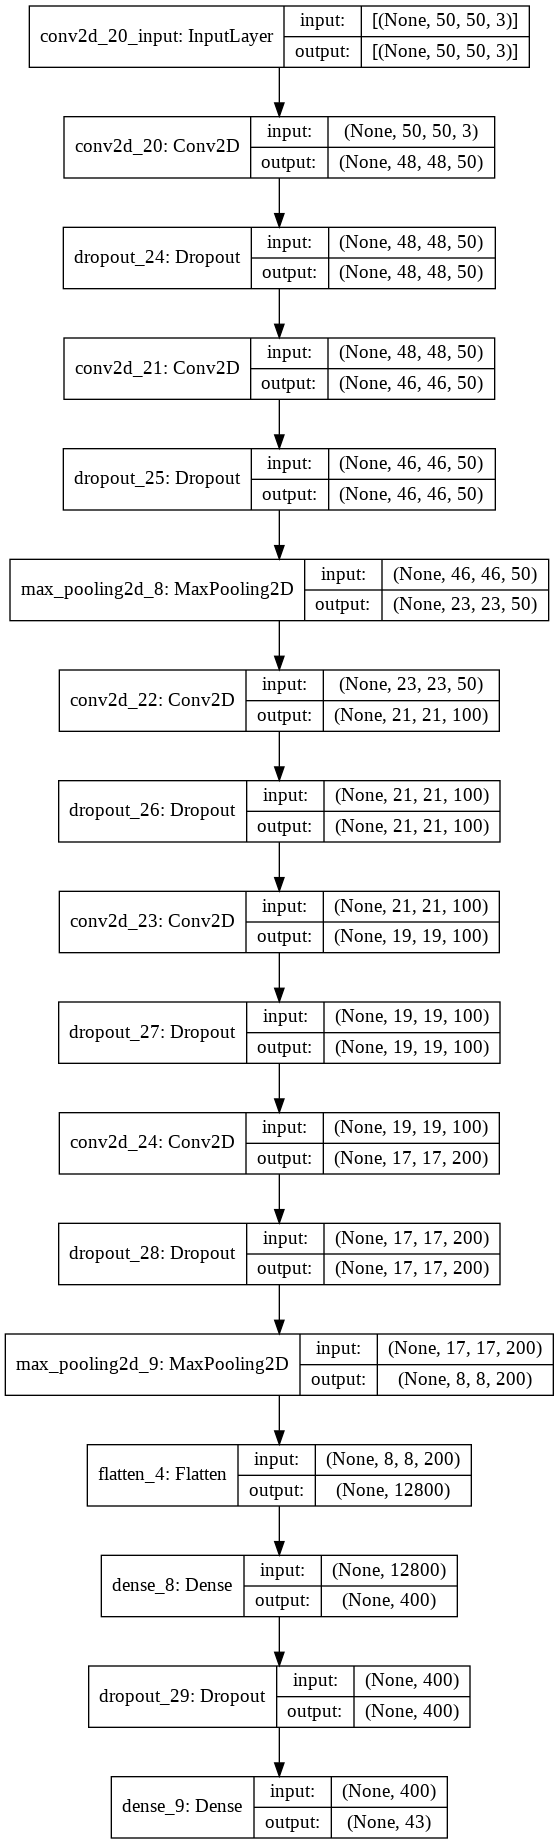

In [43]:
from IPython.display import Image
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(retina=True, filename='model.png')

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Обучение

In [45]:
history = model.fit(x_train, y_train,
                    batch_size=256,
                    epochs=20,
                    verbose=1,
                    validation_split=0.3
                    )

Train on 27446 samples, validate on 11763 samples
Epoch 1/20
27446/27446 [==============================] - 963s 35ms/sample - loss: 2.4139 - acc: 0.3501 - val_loss: 0.8602 - val_acc: 0.8161
Epoch 2/20
27446/27446 [==============================] - 959s 35ms/sample - loss: 0.5066 - acc: 0.8460 - val_loss: 0.2426 - val_acc: 0.9639
Epoch 3/20
27446/27446 [==============================] - 958s 35ms/sample - loss: 0.2306 - acc: 0.9298 - val_loss: 0.1107 - val_acc: 0.9824
Epoch 4/20
27446/27446 [==============================] - 959s 35ms/sample - loss: 0.1511 - acc: 0.9535 - val_loss: 0.0809 - val_acc: 0.9879
Epoch 5/20
27446/27446 [==============================] - 960s 35ms/sample - loss: 0.1179 - acc: 0.9639 - val_loss: 0.0503 - val_acc: 0.9913
Epoch 6/20
27446/27446 [==============================] - 955s 35ms/sample - loss: 0.0855 - acc: 0.9732 - val_loss: 0.0444 - val_acc: 0.9918
Epoch 7/20
27446/27446 [==============================] - 958s 35ms/sample - loss: 0.0714 - acc: 0.9787 

In [0]:
def plot_history(history):
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

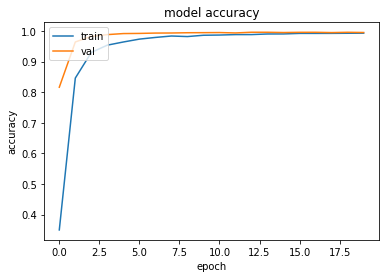

In [47]:
plot_history(history)

#### Проверка результатов

In [48]:
model.evaluate(x_test, y_test)

12630/12630 [==============================] - 108s 9ms/sample - loss: 0.0891 - acc: 0.9751


[0.0891357831557201, 0.97513855]

#### Визуализация результатов

In [0]:
def plot_prediction(image, prediction, reference_array):
    category_array = range(len(prediction))
    true_result_id = np.argmax(prediction)
    
    plt.figure(figsize=(14,10))
    
    plt.subplot(3,1,1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel("'{}' - {:0.2f}%".format(category_array[true_result_id],
                            np.max(prediction)*100),
                            color='red')

    plt.subplot(3,1,2)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(reference_array[true_result_id], cmap=plt.cm.binary)
    plt.xlabel("'{}'".format(category_array[true_result_id],
                            color='blue'))
    
    plt.subplot(3,1,2)
    plt.xticks(range(len(category_array)), category_array, rotation=45)
    thisplot = plt.bar(range(len(category_array)), prediction, color="#777777")
    plt.ylim([0,1])
    thisplot[true_result_id].set_color('red')
  
    
    plt.show()

In [0]:
predictions = model.predict(x_test)

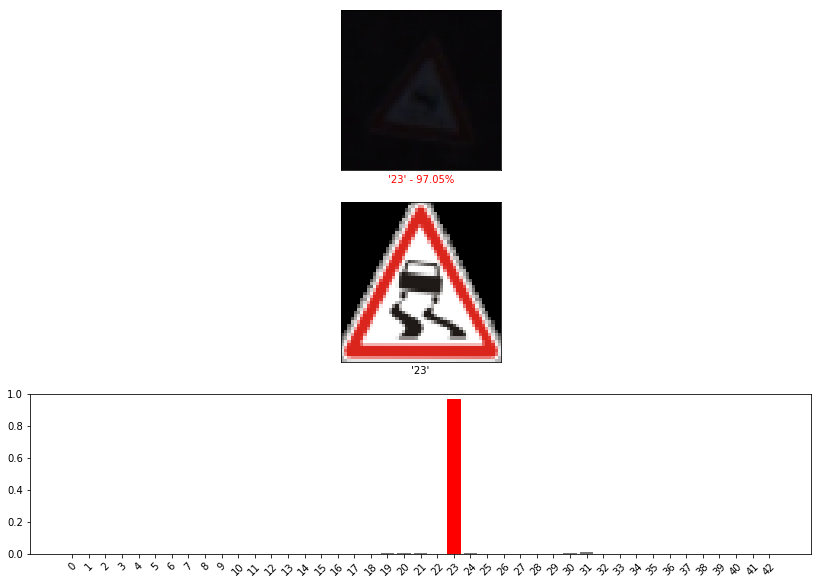

In [56]:
rand_el = random.randint(0, len(predictions)-1)
plot_prediction(x_test[rand_el], predictions[rand_el], reference_array)

####Сохранение

In [0]:
model.save('homework.h5')